In [ ]:
# Analyse mock cluster removal results
# This notebook performs bias tests on inference results from mock data

import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============== CONFIGURATION ==============

# Parameters to test and plot
# Add or remove parameters as needed
PARAMS_TO_TEST = [
    'zeropoint_dipole_mag', 
    'zeropoint_dipole_ell', 
    'zeropoint_dipole_b', 
    'sigma_v',  
    'sigma_int',
    'A_CL',
    'B_CL',
    'b1',
    'R_dist_emp',
    'n_dist_emp',
    'p_dist_emp',
]

# Number of mocks to use for bias statistics calculation
N_MOCKS_BIAS = 500

# Number of mocks to plot in the detailed posterior plots
N_MOCKS_PLOT = 20

# Results directory
RESULTS_DIR = '../results/prior_sampled_mocks_b1'

print(f"Will calculate bias statistics using {N_MOCKS_BIAS} mock(s)")
print(f"Will plot detailed posteriors for {N_MOCKS_PLOT} mock(s)")
print(f"Parameters to analyze: {PARAMS_TO_TEST}")


Will calculate bias statistics using 500 mock(s)
Will plot detailed posteriors for 20 mock(s)
Parameters to analyze: ['zeropoint_dipole_mag', 'zeropoint_dipole_ell', 'zeropoint_dipole_b', 'sigma_v', 'sigma_int', 'A_CL', 'B_CL', 'b1']


In [29]:
# Helper function to read truth values from mock DATA files (not inference results)
def read_mock_truth(mock_id, mock_data_dir=None):
    """
    Read the truth values from a mock data HDF5 file.
    
    Parameters
    ----------
    mock_id : int
        Mock identifier
    mock_data_dir : str
        Directory containing the mock data files
        
    Returns
    -------
    truth_dict : dict
        Dictionary of parameter_name -> truth_value
    """
    mock_data_path = os.path.join(mock_data_dir, f"mock_{mock_id:04d}.hdf5")
    
    if not os.path.exists(mock_data_path):
        print(f"Warning: Mock data file not found: {mock_data_path}")
        return {}
    
    truth_dict = {}
    with h5py.File(mock_data_path, 'r') as f:
        # Truth values are stored as attributes in the 'mock' group
        if 'mock' in f:
            grp = f['mock']
            for key in grp.attrs.keys():
                truth_dict[key] = grp.attrs[key]
        else:
            # Also check root attributes
            for key in f.attrs.keys():
                truth_dict[key] = f.attrs[key]
    
    return truth_dict


In [30]:
# Collect mock files
mock_full_files = []
for i in range(N_MOCKS_BIAS):
    fullfile = os.path.join(RESULTS_DIR, f'mock_{i:04d}_dipole_full.hdf5')
    if os.path.exists(fullfile):
        mock_full_files.append(fullfile)
    else:
        print(f"Warning: File not found: {fullfile}")

print(f"Found {len(mock_full_files)} mock result files")


Found 54 mock result files


In [31]:
def read_samples(path, dataset_key):
    """Read samples for a given parameter from HDF5 file."""
    with h5py.File(path, 'r') as f:
        if dataset_key not in f:
            raise KeyError(f"{dataset_key} not in {path}")
        return np.asarray(f[dataset_key][()])


In [32]:
# ============== LOAD ALL DATA FOR BIAS STATISTICS ==============
# Load samples and truths for ALL mocks (for bias calculation)

samples_by_param = {p: [] for p in PARAMS_TO_TEST}
truths_by_param = {p: [] for p in PARAMS_TO_TEST}

print(f"Loading samples and truths for {len(mock_full_files)} mocks...")

for i, fpath in enumerate(mock_full_files):
    if i % 100 == 0:
        print(f"  Processing mock {i}/{len(mock_full_files)}")
    
    # Extract mock ID from filename (e.g., "mock_0000_dipole_full.hdf5" -> 0)
    basename = os.path.basename(fpath)
    mock_id = int(basename.split('_')[1])
    
    # Read truth values from the mock DATA file (not the inference result)
    truth_dict = read_mock_truth(mock_id, RESULTS_DIR + '/mocks')
    
    # Read samples for each parameter
    for p in PARAMS_TO_TEST:
        try:
            s = read_samples(fpath, f'samples/{p}')
            samples_by_param[p].append(s)
            
            # Get truth value for this parameter
            if p in truth_dict:
                truths_by_param[p].append(truth_dict[p])
            else:
                print(f"Warning: Truth for '{p}' not found in mock {mock_id}, skipping")
                truths_by_param[p].append(np.nan)
        except Exception as e:
            print(f"Warning: mock {mock_id}, parameter '{p}': {e}")
            samples_by_param[p].append(None)
            truths_by_param[p].append(np.nan)

# Convert to arrays
for p in PARAMS_TO_TEST:
    truths_by_param[p] = np.array(truths_by_param[p])

print(f"Loaded {len(samples_by_param[PARAMS_TO_TEST[0]])} mocks successfully")


Loading samples and truths for 54 mocks...
  Processing mock 0/54
Loaded 54 mocks successfully
Loaded 54 mocks successfully


In [33]:
# DEBUG: Examine the structure of the first mock DATA file to find where truths are stored
if len(mock_full_files) > 0:
    # Get mock_id from first result file
    basename = os.path.basename(mock_full_files[0])
    mock_id = int(basename.split('_')[1])
    mock_data_path = f'{RESULTS_DIR}/mocks/mock_{mock_id:04d}.hdf5'
    
    print(f"Examining mock DATA file: {mock_data_path}\n")
    
    if os.path.exists(mock_data_path):
        with h5py.File(mock_data_path, 'r') as f:
            print("Top-level groups/datasets:")
            for key in f.keys():
                item = f[key]
                if isinstance(item, h5py.Group):
                    print(f"  {key}/ (Group)")
                else:
                    print(f"  {key}: {type(item)}")
            
            print("\n" + "="*60)
            print("Truth values (stored as attributes):")
            print("="*60)
            
            # Check 'mock' group attributes
            if 'mock' in f:
                print("\n✓ Found 'mock' group attributes:")
                grp = f['mock']
                
                # Show the parameters we're interested in
                params_of_interest = PARAMS_TO_TEST + ['sigma_v', 'sigma_int', 'A_CL', 'B_CL']
                print("\nParameters for bias test:")
                for key in params_of_interest:
                    if key in grp.attrs:
                        val = grp.attrs[key]
                        print(f"    {key} = {val}")
                
                print("\n\nAll available truth parameters:")
                for key in sorted(grp.attrs.keys()):
                    val = grp.attrs[key]
                    print(f"    {key} = {val}")
            
            # Check root attributes
            if len(f.attrs) > 0:
                print("\n✓ Root-level attributes:")
                for key in sorted(f.attrs.keys()):
                    print(f"    {key} = {f.attrs[key]}")
    else:
        print(f"Mock data file not found: {mock_data_path}")


Examining mock DATA file: ../results/prior_sampled_mocks_b1/mocks/mock_0000.hdf5

Top-level groups/datasets:
  mock/ (Group)

Truth values (stored as attributes):

✓ Found 'mock' group attributes:

Parameters for bias test:
    zeropoint_dipole_mag = 0.01910362800807888
    zeropoint_dipole_ell = 184.7341927214217
    zeropoint_dipole_b = 12.194587258432424
    sigma_v = 447.1125943827272
    sigma_int = 0.06104025729739755
    A_CL = 1.4064958850893576
    B_CL = 2.5287590256200527
    b1 = 2.564157213925188
    sigma_v = 447.1125943827272
    sigma_int = 0.06104025729739755
    A_CL = 1.4064958850893576
    B_CL = 2.5287590256200527


All available truth parameters:
    A_CL = 1.4064958850893576
    A_CL_LT = 0.0
    B_CL = 2.5287590256200527
    B_CL_LT = 2.5
    Om = 0.3
    R = 130.0
    Vext_b = 0.0
    Vext_ell = 0.0
    Vext_mag = 0.0
    b1 = 2.564157213925188
    b_min = 20.0
    beta = 0.43
    e_logF = 0.05
    e_logT = 0.03
    e_logY = 0.09
    h = 1.0
    logT_prior_mean

Creating detailed posterior plots for 20 mocks and 8 parameters...


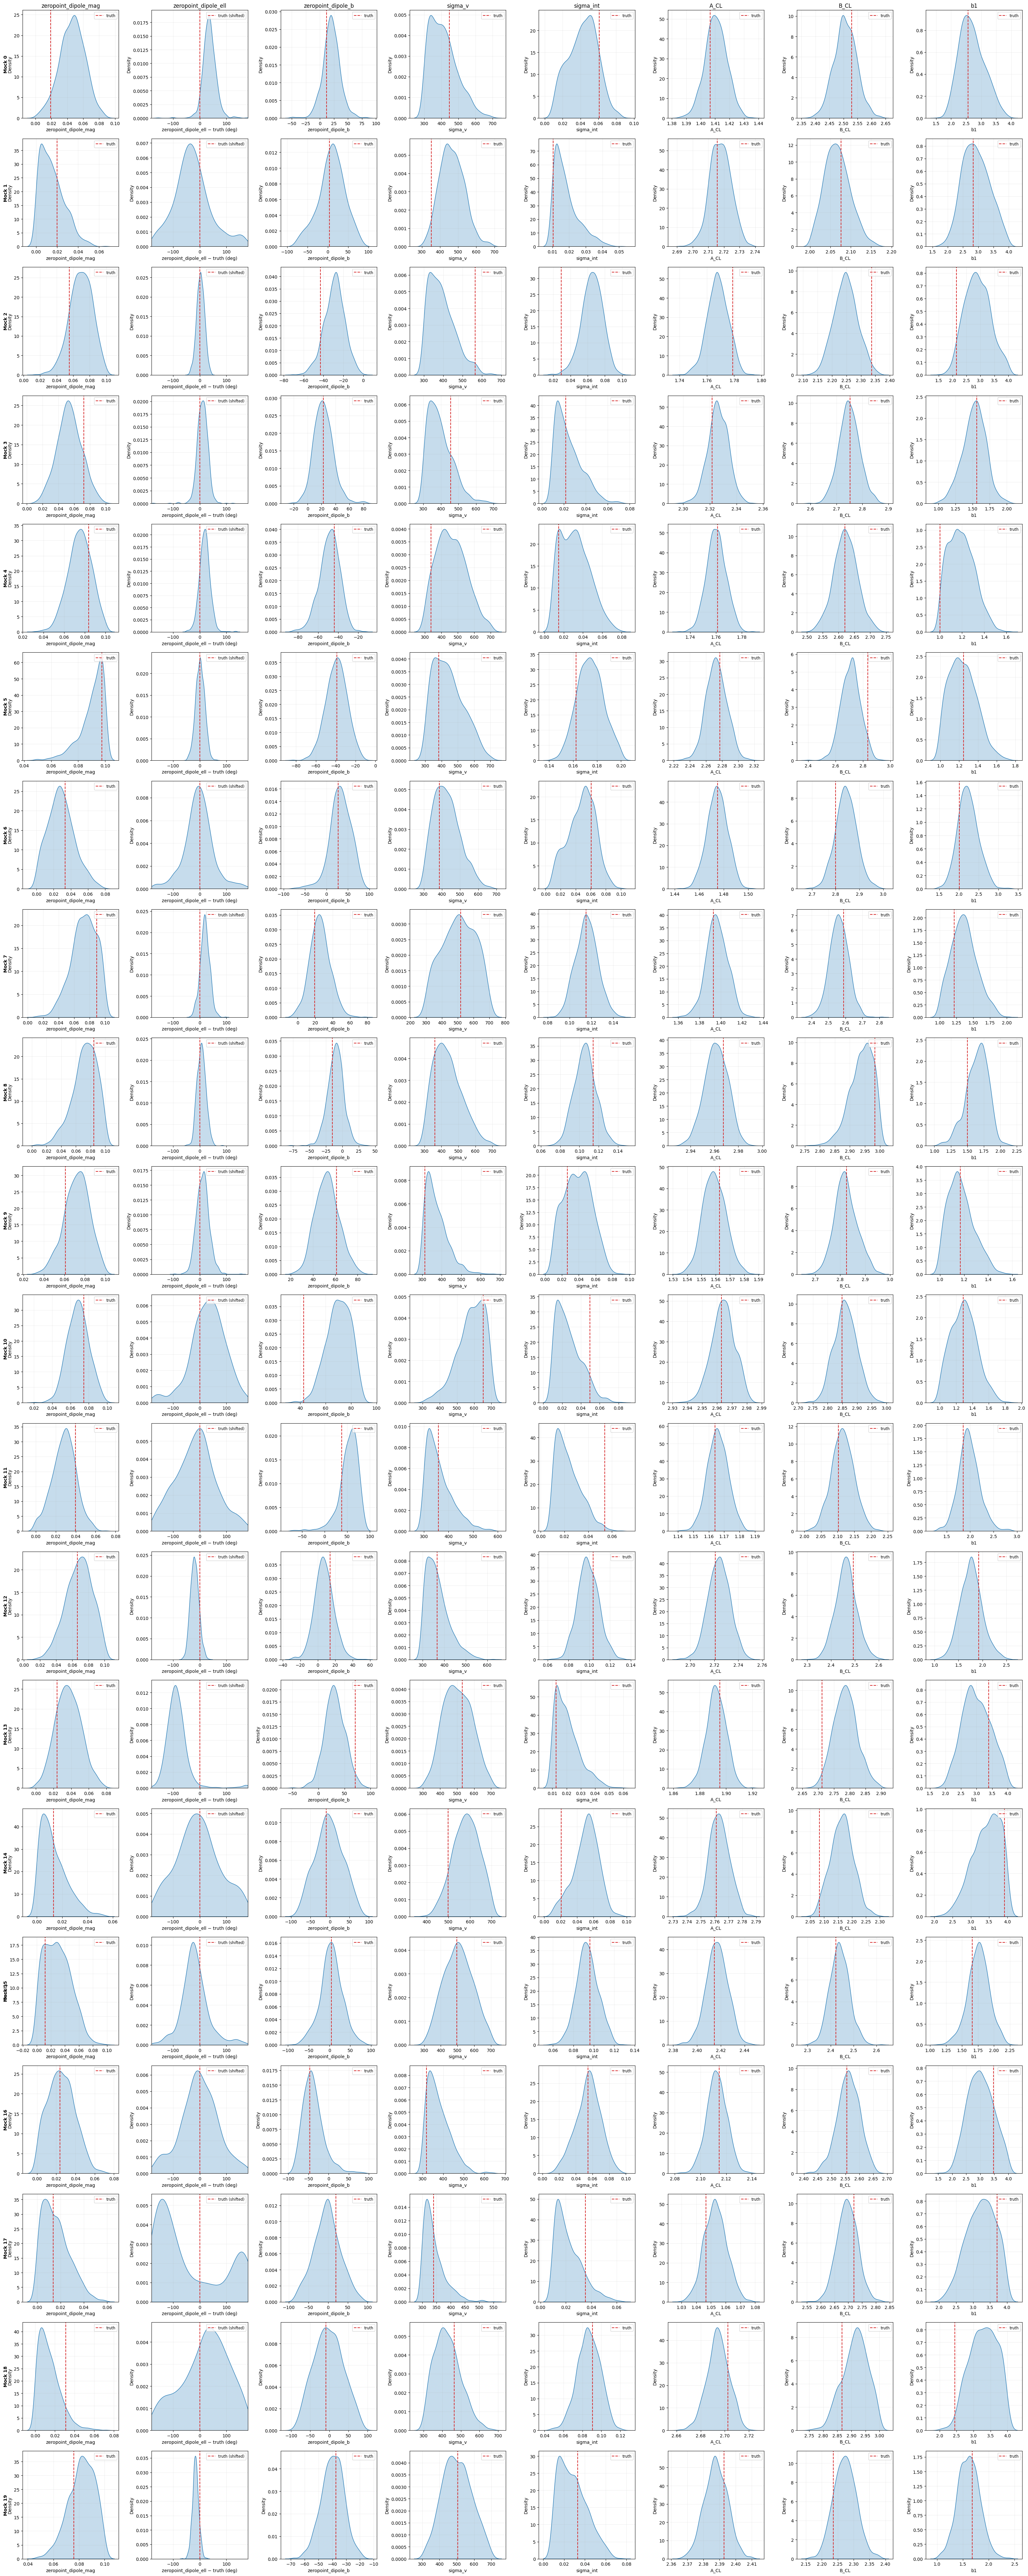

In [34]:
# ============== PLOT DETAILED POSTERIORS FOR SUBSET OF MOCKS ==============

def wrap_delta(samples_deg, truth_deg, P):
    """Wrap angular differences to (-P/2, P/2]."""
    return ((samples_deg - truth_deg + P/2) % P) - P/2

# Determine how many mocks to plot (up to N_MOCKS_PLOT)
n_plot = min(N_MOCKS_PLOT, len(mock_full_files))
n_params = len(PARAMS_TO_TEST)

print(f"Creating detailed posterior plots for {n_plot} mocks and {n_params} parameters...")

fig, axes = plt.subplots(n_plot, n_params, figsize=(4*n_params, 4*n_plot), squeeze=False)

# Parameter display settings
# All parameters are linear except for ell (circular)
param_settings = {
    'zeropoint_dipole_ell': {
        'type': 'circular',
        'period': 360.0,
        'xlim': (-180, 180)
    }
}

for i in range(n_plot):
    for j, param in enumerate(PARAMS_TO_TEST):
        ax = axes[i, j]
        
        # Get samples and truth
        samples = samples_by_param[param][i]
        truth = truths_by_param[param][i]
        
        if samples is None or not np.isfinite(truth):
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_axis_off()
            continue
        
        settings = param_settings.get(param, {})
        
        # Plot based on parameter type
        if settings.get('type') == 'circular':
            # Wrap samples around truth for circular parameters
            period = settings.get('period', 360.0)
            samples_wrapped = wrap_delta(samples, truth, period)
            sns.kdeplot(samples_wrapped, fill=True, ax=ax)
            ax.axvline(0.0, color='C3', linestyle='--', label='truth (shifted)')
            if 'xlim' in settings:
                ax.set_xlim(settings['xlim'])
            ax.set_xlabel(f'{param} − truth (deg)')
        else:
            # Linear parameter (default)
            sns.kdeplot(samples, fill=True, ax=ax)
            ax.axvline(truth, color='C3', linestyle='--', label='truth')
            ax.set_xlabel(param)
        
        if i == 0:
            ax.set_title(param)
        ax.legend(loc='upper right', fontsize='small')
        ax.grid(alpha=0.2)
    
    # Row label
    axes[i, 0].text(-0.15, 0.5, f'Mock {i}', 
                    transform=axes[i, 0].transAxes,
                    rotation=90, va='center', ha='right', 
                    fontsize='medium', fontweight='bold')

plt.tight_layout()
plt.show()

Computing bias statistics for 54 mocks...


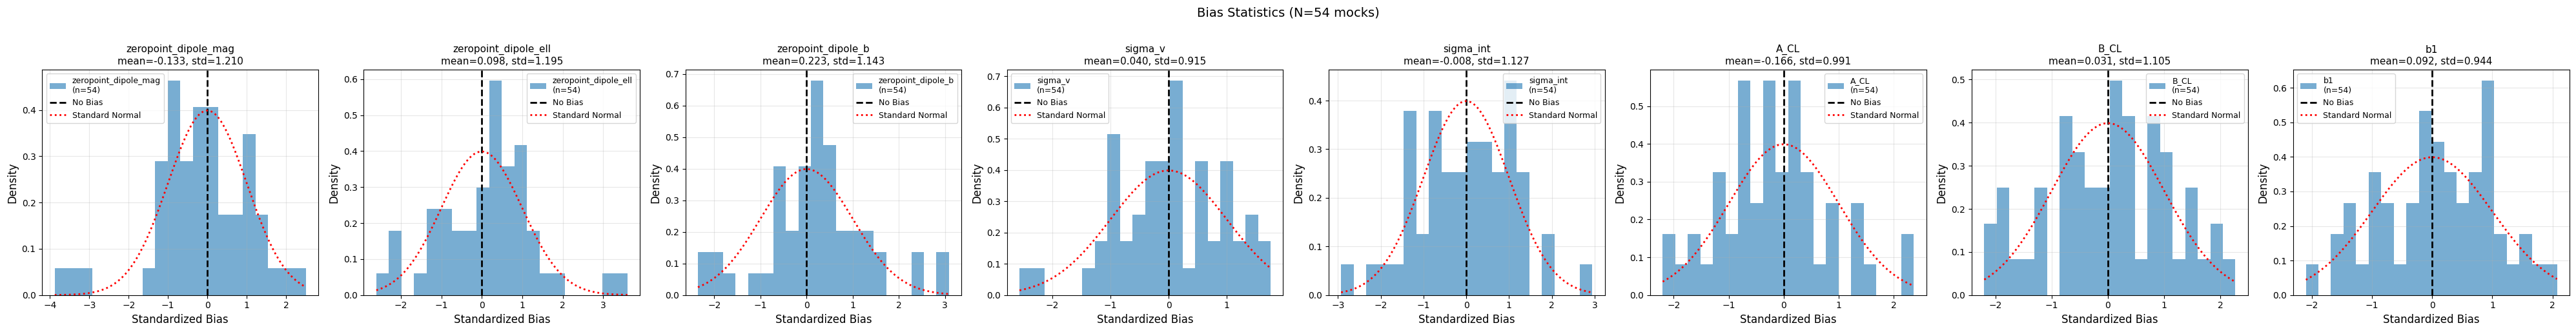

In [35]:
# ============== COMPUTE AND PLOT BIAS STATISTICS ==============
# Use ALL mocks for bias calculation

print(f"Computing bias statistics for {len(mock_full_files)} mocks...")

fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 5))
if n_params == 1:
    axes = [axes]

for i, param in enumerate(PARAMS_TO_TEST):
    # Filter out invalid entries
    valid_mask = np.array([s is not None for s in samples_by_param[param]]) & np.isfinite(truths_by_param[param])
    
    if not np.any(valid_mask):
        axes[i].text(0.5, 0.5, f'No valid data for {param}', ha='center', va='center')
        axes[i].set_axis_off()
        continue
    
    # Compute standardized biases
    biases = []
    for j, (samples, truth) in enumerate(zip(samples_by_param[param], truths_by_param[param])):
        if valid_mask[j]:
            bias = (np.mean(samples) - truth) / np.std(samples)
            biases.append(bias)
    
    biases = np.array(biases)
    
    # Plot histogram
    axes[i].hist(biases, bins=20, alpha=0.6, density=True, label=f'{param}\n(n={len(biases)})')
    axes[i].axvline(0.0, color='k', linestyle='--', linewidth=2, label='No Bias')
    
    # Overlay standard normal
    x = np.linspace(biases.min(), biases.max(), 200)
    y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x**2)
    axes[i].plot(x, y, color='red', linestyle=':', linewidth=2, label='Standard Normal')
    
    axes[i].set_xlabel('Standardized Bias', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].set_title(f'{param}\nmean={np.mean(biases):.3f}, std={np.std(biases):.3f}', 
                     fontsize=11)
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

plt.suptitle(f'Bias Statistics (N={len(mock_full_files)} mocks)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


Computing PIT values...
  Method: Rank-based SBC
  Circular randomization: False

Plotting PIT histograms...


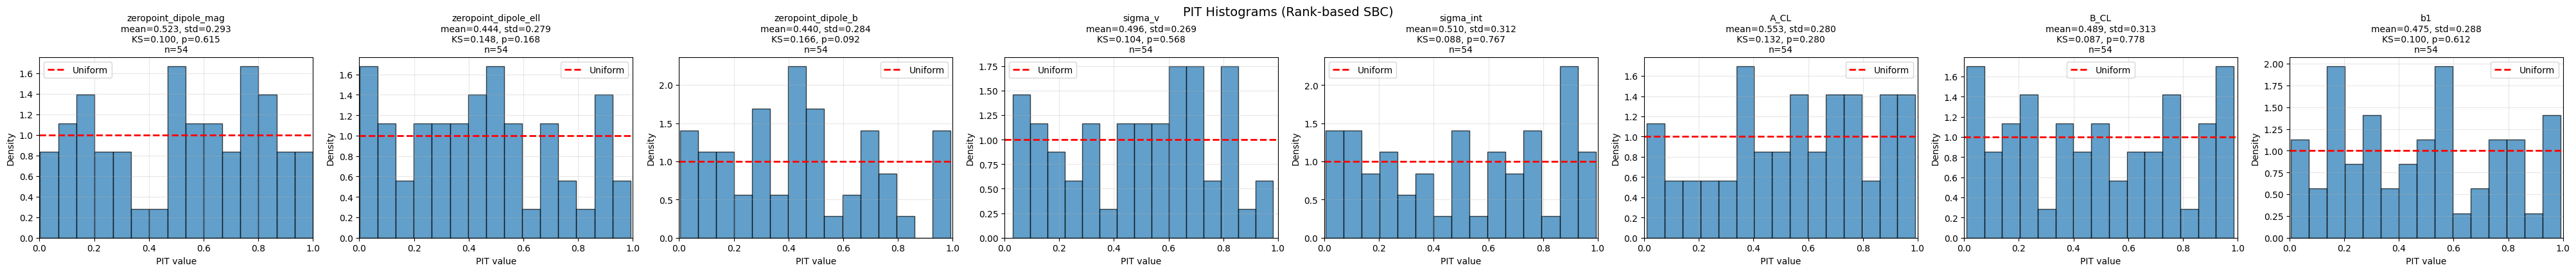


Plotting QQ plots...


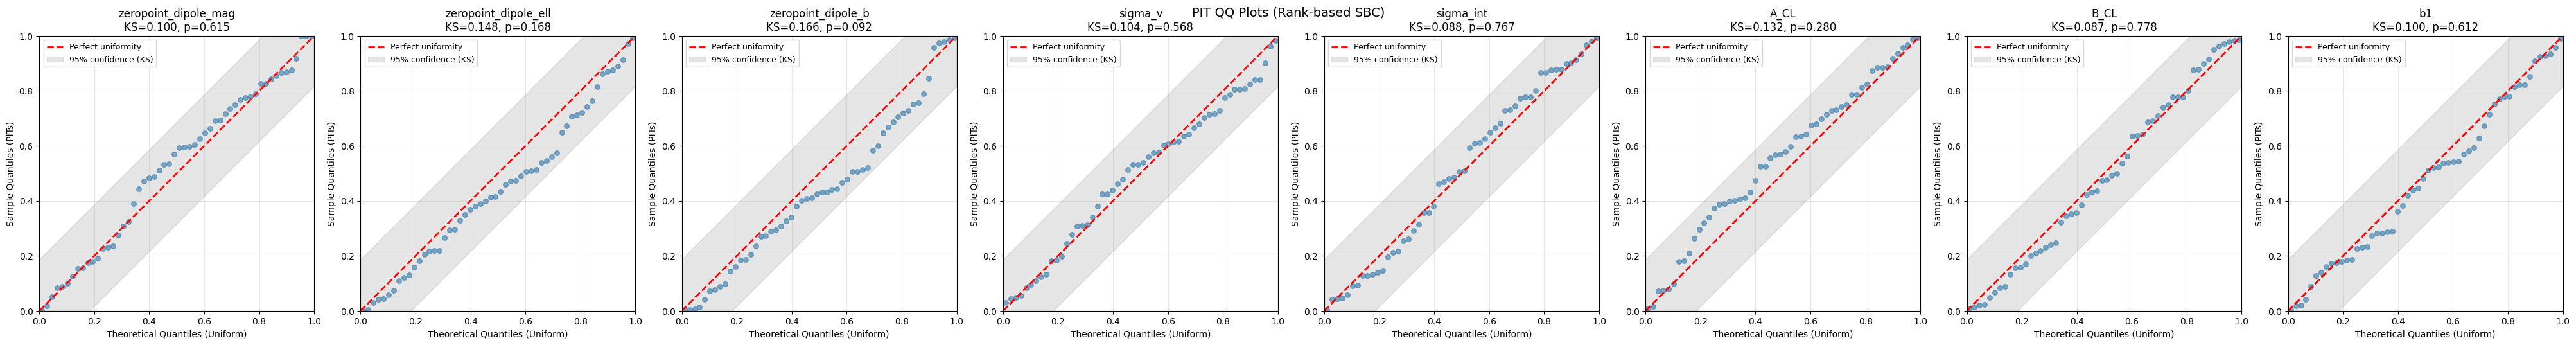

In [36]:
# ============== SBC PIT ANALYSIS WITH CONFIGURATION ==============

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ============== CONFIGURATION ==============
USE_RANK_BASED = True  # If True: rank-based SBC. If False: empirical CDF
RANDOMIZE_CIRCULAR = False  # If True: random rotation for circular params (recommended)

# ---------- Helper Functions ----------

def wrap_delta(samples_deg, truth_deg, period):
    """Return wrapped differences in (-period/2, period/2]."""
    return ((samples_deg - truth_deg + period/2) % period) - period/2

def _randomized_rank(x, s):
    """
    Return randomized rank (1..N) of truth x among samples s,
    with uniform tie-breaking. N = len(s).
    """
    s = np.asarray(s)
    N = s.size
    lt = np.sum(s < x)
    eq = np.sum(s == x)
    # random tie-break in [0, eq] (negligible for continuous floats)
    u = np.random.uniform(0.0, 1.0)
    rank = lt + 1 + int(np.floor(u * eq))  # 1..N
    return rank, N

def linear_rank_pit(samples, truth):
    """Rank-SBC PIT for linear variable."""
    r, N = _randomized_rank(truth, samples)
    return (r - 0.5) / N

def linear_cdf_pit(samples, truth):
    """Empirical CDF PIT (standard)."""
    s = np.asarray(samples)
    return (np.sum(s < truth) + 0.5*np.sum(s == truth)) / s.size

def circular_rank_pit(samples_deg, truth_deg, period=360.0, randomize=True):
    """
    Rank-SBC for circular variable.
    
    If randomize=True: applies random rotation to remove dependence on zero point.
    If randomize=False: deterministically shifts truth to zero (like plotting).
    """
    s = np.asarray(samples_deg, float) % period
    t = truth_deg % period
    
    if randomize:
        # Random rotation alpha ~ U(0, period) - recommended for SBC
        alpha = np.random.uniform(0.0, period)
        s_rot = (s + alpha) % period
        t_rot = (t + alpha) % period
        return linear_rank_pit(s_rot, t_rot)
    else:
        # Deterministic shift (truth -> 0)
        d = wrap_delta(s, t, period)
        return (np.sum(d < 0) + 0.5*np.sum(d == 0)) / d.size

def circular_cdf_pit(samples_deg, truth_deg, period=360.0):
    """PIT on a circle: fraction of samples 'to the left' of truth after wrapping."""
    d = wrap_delta(np.asarray(samples_deg), truth_deg, period)
    return (np.sum(d < 0) + 0.5*np.sum(d == 0)) / d.size

def infer_mode(name):
    """Infer parameter type from name. Only ell-like parameters are circular."""
    name = name.lower()
    if any(k in name for k in ["ell","phi","ra","lon","longitude"]):
        return ("circular", 360.0)
    return ("linear", None)

# ---------- PIT Computation ----------

def compute_pits(samples_by_param, truths_by_param, use_rank=True, randomize_circular=True, 
                 override_modes=None):
    """
    Compute PIT values for all parameters using SBC.
    
    Parameters
    ----------
    samples_by_param : dict[param] -> list of 1D arrays
        Posterior samples for each mock
    truths_by_param : dict[param] -> 1D array
        Truth values for each mock
    use_rank : bool
        If True, use rank-based PIT. If False, use empirical CDF.
    randomize_circular : bool
        If True, apply random rotation to circular parameters (recommended).
    override_modes : dict, optional
        Manual override for parameter types
        
    Returns
    -------
    pits : dict[param] -> 1D array
        PIT values for each parameter
    """
    pits = {}
    for p, arr_list in samples_by_param.items():
        truths = np.asarray(truths_by_param[p])
        if len(truths) != len(arr_list):
            raise ValueError(f"Length mismatch for {p}: {len(truths)} truths vs {len(arr_list)} sample arrays")

        mode = (override_modes or {}).get(p, infer_mode(p))
        kind, period = mode if isinstance(mode, tuple) else (mode, None)

        p_pits = []
        for i, samples in enumerate(arr_list):
            if samples is None or len(samples) == 0 or not np.isfinite(truths[i]):
                p_pits.append(np.nan)
                continue
            t = float(truths[i])

            if kind == 'circular':
                if use_rank:
                    p_pits.append(circular_rank_pit(samples, t, period=period or 360.0, randomize=randomize_circular))
                else:
                    p_pits.append(circular_cdf_pit(samples, t, period=period or 360.0))
            else:  # linear
                if use_rank:
                    p_pits.append(linear_rank_pit(samples, t))
                else:
                    p_pits.append(linear_cdf_pit(samples, t))
        pits[p] = np.asarray(p_pits, float)
    return pits

# ---------- Plotting Functions ----------

def plot_pit_histograms(pits, bins=15, use_rank=True, randomize_circular=True):
    """Plot PIT histograms for all parameters with KS test statistics."""
    params = list(pits.keys())
    n = len(params)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), constrained_layout=True)
    axes = np.atleast_1d(axes)
    
    method_str = "Rank-based SBC" if use_rank else "Empirical CDF"
    if use_rank and randomize_circular:
        method_str += " (randomized circular)"
    
    for ax, p in zip(axes, params):
        vals = np.asarray(pits[p])
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            ax.text(0.5, 0.5, f"No PITs for {p}", ha='center', va='center')
            ax.set_axis_off()
            continue
        
        ks_stat, ks_pval = stats.kstest(vals, 'uniform')
        ax.hist(vals, bins=bins, density=True, alpha=0.7, edgecolor='black')
        ax.axhline(1.0, linestyle='--', color='red', linewidth=2, label='Uniform')
        ax.set_title(f"{p}\nmean={vals.mean():.3f}, std={vals.std():.3f}\n"
                    f"KS={ks_stat:.3f}, p={ks_pval:.3f}\nn={vals.size}", fontsize=10)
        ax.set_xlim(0, 1)
        ax.set_xlabel("PIT value")
        ax.set_ylabel("Density")
        ax.grid(alpha=0.3)
        ax.legend()
    
    fig.suptitle(f"PIT Histograms ({method_str})", fontsize=14, y=1.02)
    plt.show()

def plot_pit_qq(pits, use_rank=True, randomize_circular=True):
    """Plot QQ plots for PIT values against uniform distribution."""
    params = list(pits.keys())
    n = len(params)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), constrained_layout=True)
    axes = np.atleast_1d(axes)
    
    method_str = "Rank-based SBC" if use_rank else "Empirical CDF"
    if use_rank and randomize_circular:
        method_str += " (randomized circular)"
    
    for ax, p in zip(axes, params):
        vals = np.asarray(pits[p])
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            ax.text(0.5, 0.5, f"No PITs for {p}", ha='center', va='center')
            ax.set_axis_off()
            continue
        
        vals_sorted = np.sort(vals)
        N = len(vals_sorted)
        # Better plotting positions
        theoretical = (np.arange(1, N+1) - 0.5) / N
        ks_stat, ks_pval = stats.kstest(vals, 'uniform')
        
        ax.scatter(theoretical, vals_sorted, alpha=0.6, s=30)
        ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect uniformity')
        
        # KS global 95% envelope (approximately 2-sigma)
        c = 1.36 / np.sqrt(N)
        ax.fill_between([0, 1], [0-c, 1-c], [0+c, 1+c], alpha=0.2, color='gray', 
                        label='95% confidence (KS)')
        
        ax.set_xlabel("Theoretical Quantiles (Uniform)")
        ax.set_ylabel("Sample Quantiles (PITs)")
        ax.set_title(f"{p}\nKS={ks_stat:.3f}, p={ks_pval:.3f}")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(alpha=0.3)
        ax.set_aspect('equal')
        ax.legend(fontsize=9)
    
    fig.suptitle(f"PIT QQ Plots ({method_str})", fontsize=14, y=1.02)
    plt.show()

# ============== RUN ANALYSIS ==============

print(f"Computing PIT values...")
print(f"  Method: {'Rank-based SBC' if USE_RANK_BASED else 'Empirical CDF'}")
print(f"  Circular randomization: {RANDOMIZE_CIRCULAR}")

pits = compute_pits(samples_by_param, truths_by_param, 
                    use_rank=USE_RANK_BASED, 
                    randomize_circular=RANDOMIZE_CIRCULAR)

print("\nPlotting PIT histograms...")
plot_pit_histograms(pits, bins=15, use_rank=USE_RANK_BASED, 
                   randomize_circular=RANDOMIZE_CIRCULAR)

print("\nPlotting QQ plots...")
plot_pit_qq(pits, use_rank=USE_RANK_BASED, 
           randomize_circular=RANDOMIZE_CIRCULAR)